# Waveform fitting

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Setup the notebook's environment
import lalsimulation as lalsim
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import xcp
from xcp import determine_data_fitting_region,calibration_catalog,metadata_dict

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from XCP.
(xcp.core)>> Catalog of calibration runs stored to "xcp.calibration_catalog"
(xcp.core)>> Metadata dictionary for calibration runs stored to "xcp.metadata_dict"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"


In [2]:
# Let the user know where lalsimulation lives

#
lalsim_path = lalsim.__path__[0]
lalsuite_repo_path = lalsim_path.split('lib')[0]+'src/lalsuite/'
branch_name = bash('cd %s && git status'%lalsuite_repo_path).decode("utf-8").split('On branch ')[-1].split('\n')[0]

#
alert('We are getting our LALSimulation from:\n%s'%magenta(lalsim_path))
alert('We think that the related lalsuite source files are here:\n%s'%green(lalsuite_repo_path))
alert('Lastly, we are currently on this branch: %s'%bold(magenta(branch_name)))

#
if branch_name != 'pnrv1-ll':
    alert('We are not on the expected branch. This may cause unexpected behavior.',say=True)

(notebook)>> We are getting our LALSimulation from:
/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.6/site-packages/lalsimulation
(notebook)>> We think that the related lalsuite source files are here:
/Users/book/opt/anaconda2/envs/hack-phenomx3/src/lalsuite/
(notebook)>> Lastly, we are currently on this branch: pnrv1-ll


## This notebook is for prototyping and scratch code only. Please see scripts with same issue number.

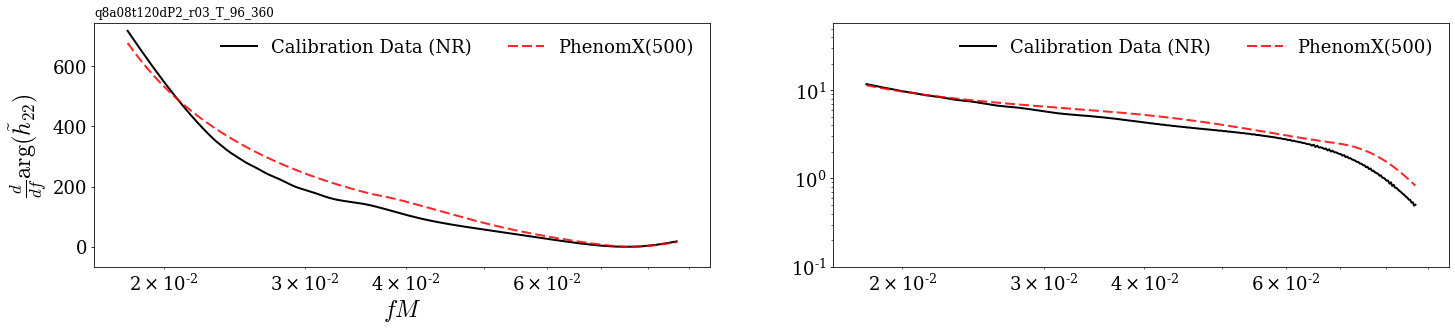

In [8]:

#
from numpy.linalg import norm
from scipy.optimize import curve_fit

#
ll = 2

#
datadir = '/Users/book/KOALA/PhenomXCP/data/version2/'
files = glob( datadir+'*_l%im%i.txt'%(ll,ll) )

#
# fig,ax = subplots( len(files), 2, figsize=3*array([ 2.5*2/(0.618), 1.5*len(files) ]) )
fig,ax = subplots( 1, 2, figsize=3*array([ 2.5*2/(0.618), 1.5*1 ]), sharex=True)
ax = ax.flatten()

#
# tight_layout(1,2,4)

#
foo = {}

#
lmlist = [ (ll,ll) ]

#
p = 0
for f_ in files[::-1]:
    
    if 'q8a08t120' in f_:#'q8a08t30' in f_:

        #
        simname = f_.split('/')[-1].split('_l%im%i.'%(ll,ll))[0]

        # Find index location of metadata for simname 
        k = list( metadata_dict['simname'] ).index(simname)

        # Load data for this case
        raw_data = loadtxt(f_).T
        calibration_data, dphi_lorentzian_min, f_min, f_max, f_lorentzian_min = determine_data_fitting_region( raw_data )

        # Collect params for this case 
        metadata = metadata_dict['array_data'][k,:]

        #
        f,amp_fd,dphi_fd,alpha,beta,gamma = calibration_data.T
        theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2,chi1_vec,chi2_vec = metadata_dict['array_data'][k]
        dphi_fd -= min( dphi_fd[ (f>0.03)&(f<0.12) ] )
        
        #
        mod_xhm_dict = xcp.get_phenomxhm_coprecessing_multipoles( f,lmlist, m1, m2, chi1_vec, chi2_vec )
        mod_xhm = mod_xhm_dict[2,2]
        mod_xhm_amp = abs(mod_xhm)
        mod_xhm_phi = unwrap( angle(mod_xhm) )
        mod_xhm_dphi = spline_diff(f,mod_xhm_phi)
        mod_xhm_dphi -= min( mod_xhm_dphi[ (f>0.03)&(f<0.12) ] )

#         # GENERATE TEMPLATE FUNCTIONS
#         # ---
#         template_amp, template_dphi, template_phi = pwca.template_amp_phase(m1, m2, chi1, chi2, chi_p)
        

#         # PHASE 
#         # ---

#         #
#         phenomd_phi = template_phi(f)
#         phi_popt, phi_pcov = curve_fit(template_phi, f, phi_td,p0=[0,0,0,0])
#         best_fit_phi = template_phi(f,*phi_popt)

#         # PHASE DERIVATIVE
#         # ---

#         #
#         phenomd_dphi = template_dphi(f)
#         dphi_popt, dphi_pcov = curve_fit(template_dphi, f, dphi_td,p0=[0,0,0,0])
#         best_fit_dphi = template_dphi(f,*dphi_popt)
#         best_fit_dphi2 = template_dphi(f,*phi_popt)
#         best_fit_phi_from_dphi_fit = template_phi(f,*dphi_popt)

#         # AMPLITUDE
#         # ---

#         #
#         amp_scale = f ** (7.0/6)
#         inv_amp_scale = f ** (-7.0/6)

#         #
#         log_scaled_template_amp = lambda X,MU0,MU1,MU2,MU3,MU4: log(  template_amp(X,MU0,MU1,MU2,MU3,MU4)*amp_scale  )
#         phenomd_amp = template_amp(f)

#         #
#         scaled_amp_fd = amp_fd * amp_scale
#         log_scaled_amp_fd = log(scaled_amp_fd)
#         log_scaled_amp_popt, log_amp_pcov = curve_fit(log_scaled_template_amp, f, log_scaled_amp_fd,p0=[0,0,0,0,0])
#         best_fit_amp = exp(log_scaled_template_amp(f,*log_scaled_amp_popt)) * inv_amp_scale

        # PLOTTING
        # ---

        #
        sca(ax[p]); p+=1
#         #plot( f, phenomd_dphi, label='PhenomD', ls='--',alpha=0.3,color='k' )
        plot( f, dphi_fd, label='Calibration Data (NR)', lw=2, alpha=1, color='k' )
        plot( f, mod_xhm_dphi, label='PhenomX(500)', ls='--',lw=2,alpha=0.85,color='r' )
        xscale('log')
        xlim(lim(f,dilate=1.1,dilate_with_multiply=True))
        ylim( limy(f, mod_xhm_dphi,dilate=0.1) )
#         plot( f, best_fit_dphi, label='Best Fit', color='r', ls='-' )
#         #plot( f, best_fit_dphi2, label='Best Fit (phi fit)', color='b', ls='-' )
        title(simname,size=12,loc='left')
        legend(ncol=3,loc=1)
        ylabel(r'$\frac{d}{df}\arg(\tilde{h}_{22})$')
        xlabel('$fM$')
#         if p==(len(files)-2):  xlabel('$fM$')
#         #
#         title(f_.split('/')[-1].split('.')[0],loc='left',size=12)

#         #subplot(1,2,2)
        sca(ax[p]); p+=1
#         plot( f, phenomd_amp, label='PhenomD', ls='--',alpha=0.9,color='k' )
        plot( f, amp_fd, label='Calibration Data (NR)', lw=2, alpha=1, color='k' )
        plot( f, mod_xhm_amp, label='PhenomX(500)', ls='--',lw=2,alpha=0.85,color='r' )
#         plot( f, best_fit_amp, label='Best Fit', color='r', ls='-' )
#         title(simname,size=12,loc='left')
        yscale('log')
        xscale('log')
        legend(ncol=3)
        ylim( limy(f, amp_fd,dilate=5) )
#         ylabel(r'$|\tilde{h}_{22}(f)|$')
#         #
#         title(f_.split('/')[-1].split('.')[0],loc='left',size=12)
        
#         #
#         figure()
#         mask = (f>0.03) & (f<0.12)
#         plot( f, phenomd_phi, label='PhenomD', ls='--',alpha=0.9,color='k' )
#         plot( f, phi_td, label='NR:Precessing', color='k', alpha=0.15, lw=6 )
#         plot( f, best_fit_phi, label='Best Fit', color='r', ls='-' )
#         plot( f, best_fit_phi_from_dphi_fit, label='Best Fit 2', color='b', ls='-' )

#         figure()
#         plot( f,best_fit_phi-phi_td, label='from phase fit' )
#         plot( f,best_fit_phi_from_dphi_fit-phi_td, label='from dphase fit' )
#         legend()
        
        #
        break
        
    

In [ ]:
?lalsim.SimIMRPhenomXPHMFrequencySequence